<a href="https://colab.research.google.com/github/diannsryh/Hospital-Reviews-Sentiment-Analysis/blob/main/albert_hospital_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

tf.__version__

'2.17.1'

In [ ]:
!pip install torch

#### **Importing Package**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification

#### **Reading Dataset**

In [ ]:
EPOCH = 50
BATCH = 32
LEARNING_RATE = 1e-6
MAX_LENGTH = 256
MODEL_PATH = "models/my-albert-202312181131.h5"

FILE_PATH = '/content/datasets/processed_hospital_reviews.csv'
df = pd.read_csv(FILE_PATH)

# Initialization of features and class labels
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].values,
    df['sentiment'].values,
    test_size=0.2,
    random_state=42
)

#### **Model Configuration**

In [ ]:
# ---- Load Pre-trained ALBERT Model ----
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

# ---- Preprocessing Data: Tokenization and Padding ----
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

# ---- Label Preprocessing ----
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}

# Normalize and convert labels to numeric
train_labels = [label.strip().capitalize() for label in train_labels]
test_labels = [label.strip().capitalize() for label in test_labels]

train_labels_numeric = [label_mapping.get(label, -1) for label in train_labels]
test_labels_numeric = [label_mapping.get(label, -1) for label in test_labels]

# Validate labels
print("Unique train labels:", set(train_labels_numeric))
print("Unique test labels:", set(test_labels_numeric))

# Handle invalid labels
if -1 in train_labels_numeric or -1 in test_labels_numeric:
    raise ValueError("Invalid labels found in dataset. Check label preprocessing.")

# ---- Class Distribution ----
train_counter = Counter(train_labels_numeric)
test_counter = Counter(test_labels_numeric)
print("Train class distribution:", train_counter)
print("Test class distribution:", test_counter)

# Compute class weights to handle imbalance
class_weights = {
    0: 1.0 / train_counter[0],
    1: 1.0 / train_counter[1],
    2: 1.0 / train_counter[2]
}

# ---- Create tf.data.Dataset for Training and Testing ----
train_dataset = tf.data.Dataset.from_tensor_slices(((train_encodings['input_ids'], train_encodings['attention_mask']), train_labels_numeric))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_encodings['input_ids'], test_encodings['attention_mask']), test_labels_numeric))

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unique train labels: {0, 1, 2}
Unique test labels: {0, 1, 2}
Train class distribution: Counter({1: 277, 2: 270, 0: 252})
Test class distribution: Counter({0: 81, 2: 63, 1: 56})


#### **Train & Test Model**

In [ ]:
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(
      train_dataset.batch(BATCH),
      epochs=EPOCH,
      validation_data=test_dataset.batch(BATCH),
      class_weight=class_weights
  )

  eval_results = model.evaluate(test_dataset.batch(BATCH))
  print("Test loss:", eval_results[0])
  print("Test accuracy:", eval_results[1])
  model.save_pretrained(MODEL_PATH)
  print(f"Model saved to {MODEL_PATH}")

Epoch 1/50
25/25 [==============================] - 35s 441ms/step - loss: 0.0188 - accuracy: 0.4018 - val_loss: 3.5608 - val_accuracy: 0.3900
Epoch 2/50
25/25 [==============================] - 2s 93ms/step - loss: 0.0138 - accuracy: 0.4593 - val_loss: 2.3388 - val_accuracy: 0.4700
Epoch 3/50
25/25 [==============================] - 2s 94ms/step - loss: 0.0104 - accuracy: 0.5707 - val_loss: 2.1810 - val_accuracy: 0.7500
Epoch 4/50
25/25 [==============================] - 2s 100ms/step - loss: 0.0098 - accuracy: 0.5845 - val_loss: 2.1240 - val_accuracy: 0.7500
Epoch 5/50
25/25 [==============================] - 2s 89ms/step - loss: 0.0064 - accuracy: 0.6270 - val_loss: 0.6074 - val_accuracy: 0.6900
Epoch 6/50
25/25 [==============================] - 2s 88ms/step - loss: 0.0048 - accuracy: 0.6308 - val_loss: 0.5532 - val_accuracy: 0.6150
Epoch 7/50
25/25 [==============================] - 2s 88ms/step - loss: 0.0037 - accuracy: 0.6909 - val_loss: 0.5147 - val_accuracy: 0.7300
Epoch 8/50

#### **Confusion Matrix**

7/7 [==============================] - 0s 60ms/step


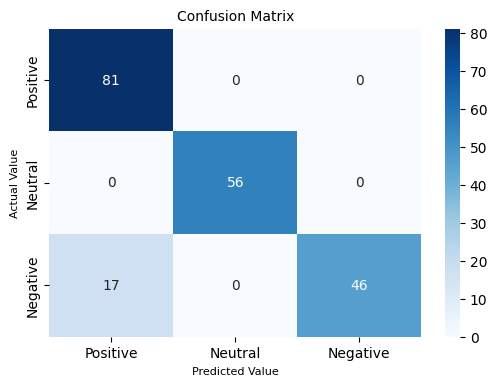



Classification Report: 
               precision    recall  f1-score   support

    Positive       0.83      1.00      0.91        81
     Neutral       1.00      1.00      1.00        56
    Negative       1.00      0.73      0.84        63

    accuracy                           0.92       200
   macro avg       0.94      0.91      0.92       200
weighted avg       0.93      0.92      0.91       200



In [ ]:
class_names = ['Positive', 'Neutral', 'Negative']
y_true = []
for _, y in test_dataset:
    y_true.append(y.numpy())
y_true = np.array(y_true)

y_pred = model.predict(test_dataset.batch(BATCH))

if isinstance(y_pred, dict):
    y_pred = y_pred['logits']

if len(y_pred.shape) == 1:
    y_pred_classes = (y_pred > 0.5).astype(int)
else:
    y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Value", fontsize=8)
plt.ylabel("Actual Value", fontsize=8)
plt.title("Confusion Matrix", fontsize=10)
plt.show()

print("\n")
print("Classification Report: \n", classification_report(y_true, y_pred_classes, target_names=class_names))

#### **Visualizing the result**

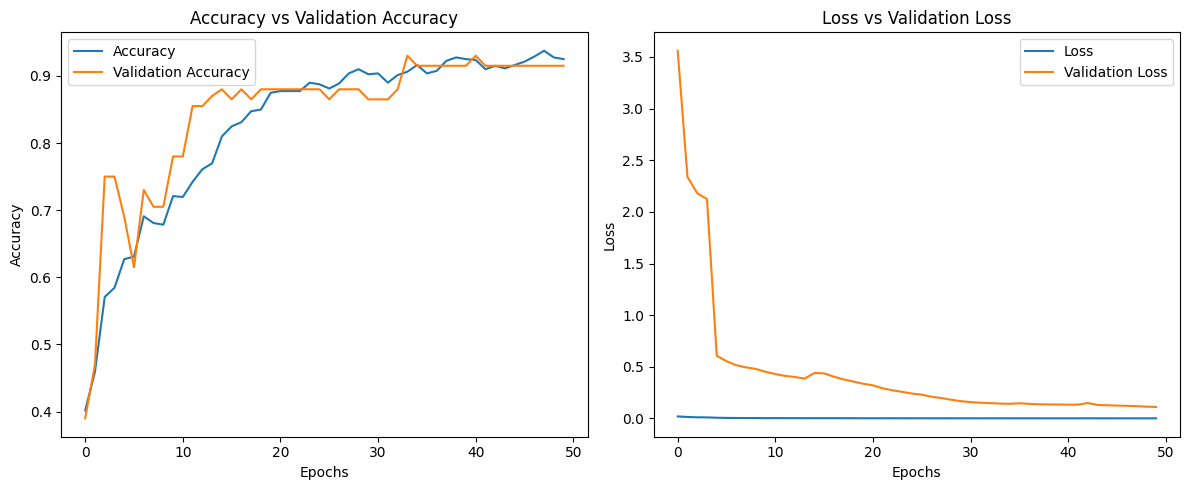

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['accuracy'], label='Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].legend()
axes[0].set_title ('Accuracy vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')

axes[1].plot(history.history['loss'], label='Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].legend()
axes[1].set_title('Loss vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

#### **Making Predictions**

In [ ]:
new_texts = ['Facilities are clean', 'The service was excellent', 'Staff were rude and unhelpful', 'The experience was fine overall',
             'The quality of service was good', 'The experience was disappointing']
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

new_input_ids = new_encodings['input_ids'].numpy()
new_attention_mask = new_encodings['attention_mask'].numpy()

predictions = model.predict([new_input_ids, new_attention_mask])
logits = predictions.logits

predicted_labels = tf.argmax(logits, axis=1).numpy()
predicted_sentiments = [list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in predicted_labels]
print("Predicted sentiments:", predicted_sentiments)

1/1 [==============================] - 0s 62ms/step
Predicted sentiments: ['Positive', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
